In [1]:
import ase.io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

from nebterpolator import traj_processor
import networkx as nx

import womblepy

In [161]:
e0_byhand = {'H': -12.336810713133827,
             'C': -145.60813964301911,
             'O': -429.04802314923108}

def makefig():
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(16)
    return fig, fig.add_subplot()

In [3]:
frames = ase.io.read("traj_0.xyz", "::4")
ase.io.write("traj.xyz", frames)
print(len(frames))

126


/home/tks32/programs/miniconda3/envs/quip_env/lib/python3.7/site-packages/ase/io/extxyz.py:843: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  'from calculator'.format(key))


# visualise the changes in the original trajectory

In [4]:
interest = traj_processor.get_connectivity_change(frames)
interest

[[84, 85], [92, 93]]

In [5]:
# chemical symbols and colors for the graphs
chemical_symbols = frames[0].get_chemical_symbols()
colors = {"H":"tab:blue", "C":"tab:gray", "O":"tab:red"}
node_colros = [colors[s] for s in chemical_symbols]

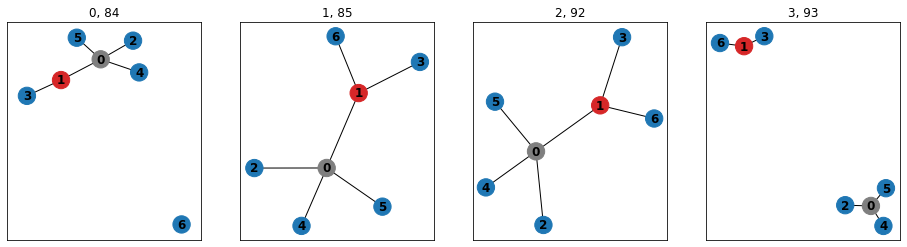

In [6]:
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(16)
gs = gridspec.GridSpec(nrows=1, ncols=4, figure=fig)

flat_interest = np.array(interest).flat[:]
for i in range(4):
    ax = fig.add_subplot(gs[i])
    nx.draw(traj_processor.atoms_to_graph(frames[flat_interest[i]]), with_labels=True, font_weight='bold', node_color=node_colros, ax=ax)
    ax.set_title("{}, {}".format(i, flat_interest[i]))
    ax.axis("on")

# smoothien the trajectory in multiple ways

In [7]:
# %%capture
# traj_processor.smooth_traj("traj.xyz", "traj_window7.xyz", smoothing_width=7)
# traj_processor.smooth_traj("traj.xyz", "traj_window11.xyz", smoothing_width=11)
# traj_processor.smooth_traj("traj.xyz", "traj_window21.xyz", smoothing_width=21)
# traj_processor.smooth_traj("traj.xyz", "traj_window31.xyz", smoothing_width=31)
# traj_processor.smooth_traj("traj.xyz", "traj_window41.xyz", smoothing_width=41)
# traj_processor.smooth_traj("traj.xyz", "traj_window61.xyz", smoothing_width=61)

In [8]:
# for i in [7, 11, 21, 31, 41, 61]:
#     print("! /home/tks32/work/oxidation_gap/womblepy/scripts/run_quip.sh traj_window{i}.xyz gap_window{i}.xyz".format(i=i)) 

In [9]:
# ! /home/tks32/work/oxidation_gap/womblepy/scripts/run_quip.sh traj_window7.xyz gap_window7.xyz
# ! /home/tks32/work/oxidation_gap/womblepy/scripts/run_quip.sh traj_window11.xyz gap_window11.xyz
# ! /home/tks32/work/oxidation_gap/womblepy/scripts/run_quip.sh traj_window21.xyz gap_window21.xyz
# ! /home/tks32/work/oxidation_gap/womblepy/scripts/run_quip.sh traj_window31.xyz gap_window31.xyz
# ! /home/tks32/work/oxidation_gap/womblepy/scripts/run_quip.sh traj_window41.xyz gap_window41.xyz
# ! /home/tks32/work/oxidation_gap/womblepy/scripts/run_quip.sh traj_window61.xyz gap_window61.xyz

# potential and optimisations

In [10]:
from quippy.potential import Potential
from ase.optimize.fire import FIRE
gap_path = "/home/tks32/work/oxidation_gap/fitting_iterations/iter_7.0_collide/gap_model/GAP.xml"
pot = Potential("", param_filename=gap_path)

In [11]:
def opt_frame(atoms, traj=None, **kwargs):
    local_at = atoms.copy()
    local_at.set_calculator(pot)
    opt = FIRE(local_at, trajectory=traj)
    opt.run(**kwargs)
    return local_at

In [12]:
trajectories = {"orig": ase.io.read("traj.xyz", ":"),
                7 : ase.io.read("gap_window7.xyz", ":"),
                11: ase.io.read("gap_window11.xyz", ":"),
                21: ase.io.read("gap_window21.xyz", ":"),
                31: ase.io.read("gap_window31.xyz", ":"),
                41: ase.io.read("gap_window41.xyz", ":"),
#                 61: ase.io.read("gap_window61.xyz", ":")
               }

In [114]:
x_opt = np.arange(0, len(trajectories["orig"]), 5)

frame_before = trajectories[41][::5]  # same 5fs interval from the 0.25 original * 4 cut earlier
frames_opt = []

for i, at in enumerate(frame_before):
    traj = "relax_{}.traj".format(i)
    xyz = "relax_{}.xyz".format(i)
    
    frames_opt.append(opt_frame(at, traj=traj, steps=60, fmax=0.2))
    ase.io.write(xyz, ase.io.read(traj, ":"))

# save file
ase.io.write("relaxed_frames.xyz", frames_opt)


# # read from file
# frames_opt = ase.io.read("relaxed_frames.xyz", ":")

# for at in frames_opt:
#     at.set_calculator(pot)
#     at.get_potential_energy()


      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 14:42:52     -670.068788*       0.6521
FIRE:    1 14:42:52     -670.073813*       0.3378
FIRE:    2 14:42:52     -670.076904*       0.4394
FIRE:    3 14:42:52     -670.081586*       0.3253
FIRE:    4 14:42:52     -670.085481*       0.2154
FIRE:    5 14:42:53     -670.087331*       0.4457
FIRE:    6 14:42:53     -670.091982*       0.2691
FIRE:    7 14:42:53     -670.097543*       0.3678
FIRE:    8 14:42:53     -670.106754*       0.3266
FIRE:    9 14:42:53     -670.120222*       0.3581
FIRE:   10 14:42:53     -670.140595*       0.4387
FIRE:   11 14:42:53     -670.173198*       0.5382
FIRE:   12 14:42:53     -670.225367*       0.5876
FIRE:   13 14:42:53     -670.286345*       0.3961
FIRE:   14 14:42:53     -670.316068*       0.7709
FIRE:   15 14:42:53     -670.323648*       0.2406
FIRE:   16 14:42:53     -670.323141*       0.5529
FIRE:   17 14:42:53     -670.324769*       0.4364
FI

FIRE:   26 14:43:00     -671.049620*       0.3544
FIRE:   27 14:43:00     -671.052445*       0.2763
FIRE:   28 14:43:00     -671.055006*       0.1845
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 14:43:00     -670.444222*       4.4011
FIRE:    1 14:43:00     -670.606021*       1.1710
FIRE:    2 14:43:00     -670.569517*       2.6889
FIRE:    3 14:43:00     -670.610336*       2.2468
FIRE:    4 14:43:00     -670.666224*       1.3891
FIRE:    5 14:43:00     -670.699654*       0.9560
FIRE:    6 14:43:00     -670.699610*       1.8861
FIRE:    7 14:43:01     -670.703375*       1.7975
FIRE:    8 14:43:01     -670.710231*       1.6291
FIRE:    9 14:43:01     -670.719010*       1.3990
FIRE:   10 14:43:01     -670.728362*       1.1366
FIRE:   11 14:43:01     -670.737145*       0.9132
FIRE:   12 14:43:01     -670.744782*       0.8961
FIRE:   13 14:43:01     -670.751458*       0.8753
FIRE:   14 14:43:01     -670.758668*       0.8481
FI

FIRE:   19 14:43:06     -671.064418*       0.3567
FIRE:   20 14:43:06     -671.066325*       0.2166
FIRE:   21 14:43:06     -671.067826*       0.1790
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 14:43:06     -670.355536*       1.3054
FIRE:    1 14:43:06     -670.382436*       0.7204
FIRE:    2 14:43:06     -670.402882*       0.8488
FIRE:    3 14:43:06     -670.422883*       0.7732
FIRE:    4 14:43:07     -670.447822*       0.8912
FIRE:    5 14:43:07     -670.481668*       0.9390
FIRE:    6 14:43:07     -670.534143*       0.7059
FIRE:    7 14:43:07     -670.589659*       0.7651
FIRE:    8 14:43:07     -670.656924*       0.8956
FIRE:    9 14:43:07     -670.764629*       1.1526
FIRE:   10 14:43:07     -670.931824*       1.1833
FIRE:   11 14:43:07     -671.050023*       0.6236
FIRE:   12 14:43:07     -671.055297*       0.4437
FIRE:   13 14:43:07     -671.060510*       0.2338
FIRE:   14 14:43:07     -671.062741*       0.3621
FI

FIRE:    1 14:43:12     -670.837597*       0.5846
FIRE:    2 14:43:12     -670.831168*       1.1688
FIRE:    3 14:43:12     -670.841023*       0.9221
FIRE:    4 14:43:12     -670.854870*       0.8182
FIRE:    5 14:43:12     -670.866491*       0.9041
FIRE:    6 14:43:12     -670.876969*       1.1616
FIRE:    7 14:43:12     -670.895436*       1.4164
FIRE:    8 14:43:12     -670.931456*       1.6098
FIRE:    9 14:43:12     -670.989975*       1.7850
FIRE:   10 14:43:12     -671.083732*       1.9991
FIRE:   11 14:43:12     -671.219728*       1.9790
FIRE:   12 14:43:12     -671.360327*       1.5801
FIRE:   13 14:43:12     -671.363583*       3.2290
FIRE:   14 14:43:13     -671.391852*       2.8494
FIRE:   15 14:43:13     -671.435880*       2.1763
FIRE:   16 14:43:13     -671.477986*       1.3344
FIRE:   17 14:43:13     -671.505287*       0.9916
FIRE:   18 14:43:13     -671.517672*       1.2177
FIRE:   19 14:43:13     -671.525097*       1.6693
FIRE:   20 14:43:13     -671.536611*       1.8511


FIRE:   31 14:43:18     -671.704815*       0.2662
FIRE:   32 14:43:18     -671.706754*       0.2287
FIRE:   33 14:43:18     -671.708824*       0.1845
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 14:43:18     -671.327860*       3.0614
FIRE:    1 14:43:18     -671.448684*       0.8674
FIRE:    2 14:43:18     -671.381607*       3.5022
FIRE:    3 14:43:18     -671.429949*       2.0360
FIRE:    4 14:43:18     -671.464266*       0.5515
FIRE:    5 14:43:18     -671.461849*       0.9949
FIRE:    6 14:43:18     -671.463001*       0.9404
FIRE:    7 14:43:18     -671.465057*       0.8352
FIRE:    8 14:43:18     -671.467581*       0.6868
FIRE:    9 14:43:18     -671.470050*       0.5093
FIRE:   10 14:43:18     -671.471994*       0.3313
FIRE:   11 14:43:18     -671.473152*       0.2694
FIRE:   12 14:43:18     -671.473619*       0.2888
FIRE:   13 14:43:18     -671.473820*       0.4127
FIRE:   14 14:43:18     -671.473904*       0.4060
FI

In [17]:
ener = dict()

for key, val in  trajectories.items():
    ener[key] = womblepy.testing.extract_energies(val, e0=e0_byhand)

ener_relax = womblepy.testing.extract_energies(frames_opt, e0=e0_byhand)

# analyse the results


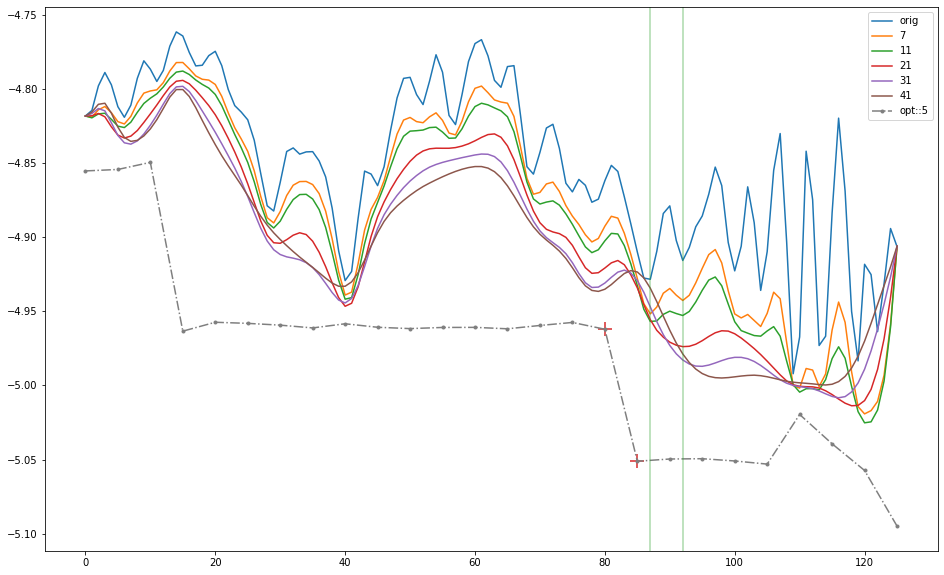

In [162]:
fig, ax = makefig()

for key, val in ener.items():
    ax.plot(val, label=key)
# ax.scatter(-4, ener_0, c="k", marker="+")
# ax.scatter(0, ener_1, c="tab:red", marker="+")

ax.plot(x_opt, ener_relax, marker=".", linestyle="-.", c="tab:gray", label="opt::5")

# index for change in the relaxed frames
relax_index = traj_processor.get_connectivity_change(frames_opt)[0]
ax.scatter(x_opt[relax_index], ener_relax[relax_index], marker="+", c="tab:red", s=200)

# for the right one now
interest_in_traj = traj_processor.get_connectivity_change(trajectories[41])
interest = np.min(interest_in_traj), np.max(interest_in_traj)

for pair in interest:
    ax.axvline(np.mean(pair), c="tab:green", alpha=0.4)

l = ax.legend()

In [32]:
relax_index

[16, 17]

In [35]:
def print_mols(i):
    molecules = traj_processor.get_molecules_in_graph(traj_processor.atoms_to_graph(frames_opt[i]))
    for mol in molecules:
        print(mol.nodes)

In [40]:
print_mols(16)
print_mols(17)
print_mols(-1)

[0, 1, 2, 3, 4, 5]
[6]
[0, 2, 4, 5]
[1, 3, 6]
[0, 2, 4, 5]
[1, 3, 6]


In [119]:
# auxillary calculations, to have them at one place
interest_in_traj = traj_processor.get_connectivity_change(trajectories[41])


#---------------------------
# settings for the NEB
#---------------------------
n_relax = 6 # from both
n_traj = 6 # from inbetween
# what we need to get -- based on the plot
# frames 16 and 19 from the relaxed ones
# frames between 80 and 95 in the trajectory


relax_indices = np.array([
    np.argwhere(np.abs(np.diff(np.less_equal(x_opt, np.min(interest_in_traj))))).flat[0],
    np.argwhere(np.abs(np.diff(np.greater_equal(x_opt, np.max(interest_in_traj))))).flat[0] + 1
]) # this is the ends of the NEB, indices of the relaxed set

trajectory_bounds = x_opt[relax_indices]


interest_in_traj, trajectory_bounds, relax_index

([[87, 88], [91, 92]], array([85, 95]), [16, 17])

In [107]:
# def interval_index(n_chosen, start, end, down=True):
#     a = start + (end - start) * np.arange(n_chosen) / (n_chosen - 1)
    
#     if down:
#         return np.array(np.floor(a), dtype=int)
#     else:
#         return np.array(np.ceil(a), dtype=int)

# def construct_images(traj, start_relax_traj, end_relax_traj, start, end, traj_index, n_traj=6, n_relax=6):
#     # start 
#     images = [start.copy()]
    
#     # start relax backwards
#     for i in interval_index(n_relax, 0, - len(start_relax_traj) + 4):
#         images.append(start_relax_traj[i].copy())
        
#     # trajectory forward
#     for i in interval_index(n_traj, *traj_index):
#         images.append(traj[i].copy())
        
#     # end relax forward
#     for i in interval_index(n_relax, 1, len(end_relax_traj) - 4):
#         images.append(end_relax_traj[i].copy())
        
#     # end frame
#     images.append(end.copy())
        
#     for at in images:
#         at.set_calculator(pot)
        
#     return images
    
    

In [108]:
images_41 = construct_images(traj=trajectories[41],
                             start_relax_traj=ase.io.read("relax_16.xyz", ":"),
                             end_relax_traj=ase.io.read("relax_19.xyz", ":"),
                             start=frames_opt[16],
                             end=frames_opt[19],
                             traj_index=[80, 95])

In [113]:
ase.io.write("stat_images_41.xyz", [frames_opt[16]]+trajectories[41][80:95]+[frames_opt[19]])

# manual NEB now

In [122]:
core_images = trajectories[41][80:100:3]
len(core_images)

In [130]:
start = opt_frame(core_images[0], traj="forneb_start.traj")

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 14:53:09     -670.886146*       2.3489
FIRE:    1 14:53:09     -670.949218*       1.3798
FIRE:    2 14:53:09     -670.976197*       1.3592
FIRE:    3 14:53:09     -670.987362*       1.1141
FIRE:    4 14:53:09     -671.002220*       0.7406
FIRE:    5 14:53:09     -671.011908*       0.6479
FIRE:    6 14:53:09     -671.014853*       0.9387
FIRE:    7 14:53:09     -671.015786*       0.8988
FIRE:    8 14:53:10     -671.017496*       0.8221
FIRE:    9 14:53:10     -671.019706*       0.7151
FIRE:   10 14:53:10     -671.022091*       0.5876
FIRE:   11 14:53:10     -671.024356*       0.4538
FIRE:   12 14:53:10     -671.026323*       0.3927
FIRE:   13 14:53:10     -671.027987*       0.3844
FIRE:   14 14:53:10     -671.029653*       0.4140
FIRE:   15 14:53:10     -671.031580*       0.4642
FIRE:   16 14:53:10     -671.034062*       0.4682
FIRE:   17 14:53:10     -671.037218*       0.4155
FI

In [131]:
end = opt_frame(core_images[-1], traj="forneb_end.traj")

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 14:53:12     -671.305056*       2.4617
FIRE:    1 14:53:12     -671.382300*       1.3919
FIRE:    2 14:53:12     -671.407037*       1.7323
FIRE:    3 14:53:12     -671.418909*       1.4398
FIRE:    4 14:53:12     -671.435736*       0.9500
FIRE:    5 14:53:12     -671.449849*       0.6578
FIRE:    6 14:53:12     -671.459749*       0.9803
FIRE:    7 14:53:13     -671.470368*       1.2048
FIRE:    8 14:53:13     -671.486269*       1.2246
FIRE:    9 14:53:13     -671.507439*       1.0541
FIRE:   10 14:53:13     -671.532134*       0.7251
FIRE:   11 14:53:13     -671.554669*       0.6085
FIRE:   12 14:53:13     -671.576608*       0.8559
FIRE:   13 14:53:13     -671.603889*       0.6350
FIRE:   14 14:53:13     -671.630043*       0.5110
FIRE:   15 14:53:13     -671.649961*       0.6926
FIRE:   16 14:53:13     -671.669429*       0.6016
FIRE:   17 14:53:13     -671.686211*       0.2968
FI

In [140]:
path_start = ase.io.read("forneb_start.traj", ":")#[1:-1:9]
path_end = ase.io.read("forneb_end.traj", ":")#[1:-1:12]

print(len(path_start), len(path_end))

61 86


In [144]:
# start             .... this backwatds
images_temp = [start] + path_start[1:-1:9][::-1] + core_images + path_end[1:-1:12] + [end]

In [145]:
ase.io.write("try.xyz", images_temp)

In [146]:
images = []
for at in images_temp:
    atcopy = at.copy()
    atcopy.set_calculator(pot)
    images.append(atcopy)

In [147]:
from ase.neb import SingleCalculatorNEB

In [148]:
neb = SingleCalculatorNEB(images)
neb_fire = FIRE(neb, trajectory="manual_neb_trajectory.traj")

In [149]:
neb_fire.run(steps=50)

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 14:57:43     -670.811946*       2.7649
FIRE:    1 14:57:44     -670.850623*       2.4223
FIRE:    2 14:57:44     -670.860568*       1.9195
FIRE:    3 14:57:45     -670.903341*       3.0895
FIRE:    4 14:57:46     -670.911751*       2.4748
FIRE:    5 14:57:46     -670.923940*       1.4464
FIRE:    6 14:57:47     -670.934662*       0.8995
FIRE:    7 14:57:48     -670.943453*       1.5391
FIRE:    8 14:57:48     -670.944437*       1.4860
FIRE:    9 14:57:49     -670.946316*       1.3821
FIRE:   10 14:57:49     -670.948932*       1.2328
FIRE:   11 14:57:50     -670.952107*       1.0484
FIRE:   12 14:57:51     -670.955682*       0.8477
FIRE:   13 14:57:51     -670.959571*       0.6647
FIRE:   14 14:57:52     -670.963775*       0.6377
FIRE:   15 14:57:53     -670.968866*       0.6396
FIRE:   16 14:57:53     -670.975139*       0.7793
FIRE:   17 14:57:54     -670.982935*       0.8741
FI

False

In [150]:
ase.io.write("neb_save_50.xyz", images)

/home/tks32/programs/miniconda3/envs/quip_env/lib/python3.7/site-packages/ase/io/extxyz.py:843: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  'from calculator'.format(key))


In [153]:
ener_neb = womblepy.testing.extract_energies(images, e0=e0_byhand)

array([-4.96957852, -4.96930926, -4.96873941, -4.96806906, -4.96613133,
       -4.96831934, -4.96520903, -4.96359639, -4.96668959, -4.96827892,
       -5.01952329, -5.05310798, -5.05154165, -5.05281252, -5.05324307,
       -5.05142621, -5.05133068, -5.05349527, -5.05458484, -5.05514591,
       -5.05541586, -5.05576751, -5.05680843])

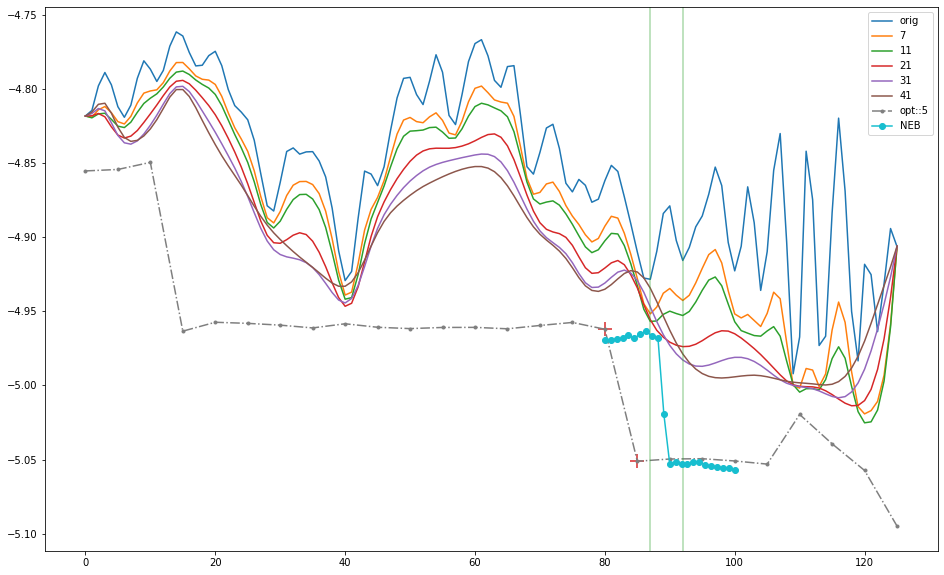

In [163]:
fig, ax = makefig()

for key, val in ener.items():
    ax.plot(val, label=key)
# ax.scatter(-4, ener_0, c="k", marker="+")
# ax.scatter(0, ener_1, c="tab:red", marker="+")

ax.plot(x_opt, ener_relax, marker=".", linestyle="-.", c="tab:gray", label="opt::5")

# index for change in the relaxed frames
relax_index = traj_processor.get_connectivity_change(frames_opt)[0]
ax.scatter(x_opt[relax_index], ener_relax[relax_index], marker="+", c="tab:red", s=200)

# for the right one now
interest_in_traj = traj_processor.get_connectivity_change(trajectories[41])
interest = np.min(interest_in_traj), np.max(interest_in_traj)

for pair in interest:
    ax.axvline(np.mean(pair), c="tab:green", alpha=0.4)
#-----------------------------------------------------------------------


x_neb = np.linspace(80, 100, len(images))
ax.plot(x_neb, ener_neb, c="tab:cyan", label="NEB", marker="o")




#-----------------------------------------------------------------------
l = ax.legend()







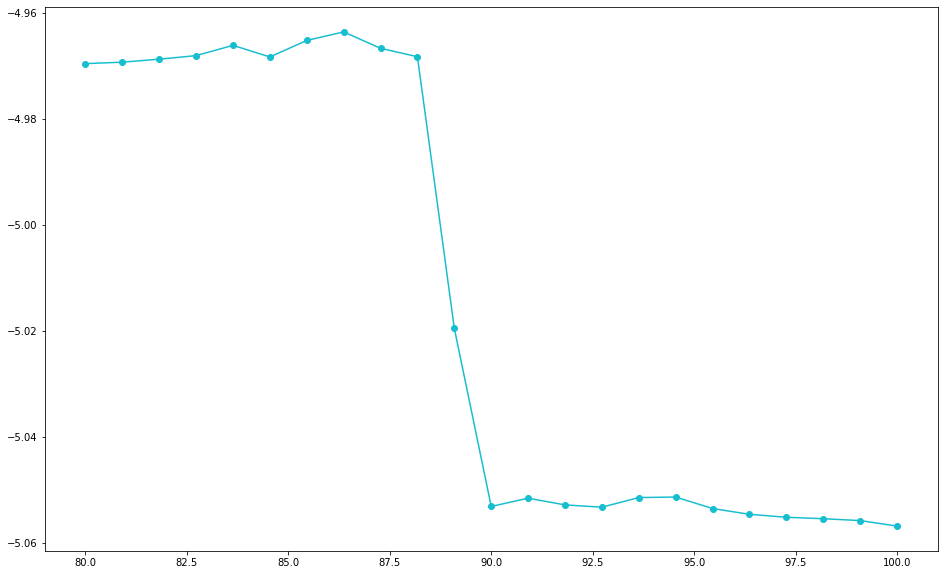

In [164]:
fig, ax = makefig()
x_neb = np.linspace(80, 100, len(images))
ax.plot(x_neb, ener_neb, c="tab:cyan", label="NEB", marker="o")


In [ ]:
trajectories[41][-1].